# Tutorial - Green Urban Scenarious
A demo of a minimal flow of GUS process.

For more advanced use cases, please see upcoming article. For more structured experiment and scenario analyis plese see model sepcification and code documentation within docs/ folder. 

In [ ]:
# Install the GUS framework.

import sys
!{sys.executable} -m pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple gus==0.1.7

In [1]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 3
%matplotlib inline
from pkg_resources import resource_filename
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os, sys, json
import pkgutil
import pprint
pp = pprint.PrettyPrinter(indent=1)
sns.set_theme()

## 0. Importing GUS modules

In [9]:
from src.gus.models import Urban
from src.gus.utilities import get_raster_data

## 1. Initilisation

### 1.1 Importing data on site, tree populations, experiment parameters

In [2]:
import logging
logfile = os.path.join("src", "gus/outputs/gus.log")
logging.basicConfig(filename=logfile, format='%(asctime)s %(levelname)s %(message)s', level=logging.INFO)

# File that holds site/city other geolocated data and parameters
fname_config_site = pkgutil.get_data("src", "gus/inputs/site.json")
ff_config_site = resource_filename("src", "gus/inputs/allometrics.json")

# File that include tree species specific parameters
fname_config_allometrics = resource_filename("src", "gus/inputs/allometrics.json")
s_config_allometrics = pkgutil.get_data("src", "gus/inputs/allometrics.json")

# File that include individual tree data including their location on a 2D raster of the actual location
fname_data_trees = pkgutil.get_data("src", "gus/inputs/trees.csv")
pp.pprint(fname_data_trees)

# File that holds experiment parameters
fname_scenario_params = pkgutil.get_data("src", "gus/inputs/scenario.json")

(b'id,species,dbh,height,condition,xpos,ypos\n1,conifer,13.363789930251517,3'
 b'.4138359452433384,fair,0,1\n2,conifer,12.040395035201806,3.48239796129288'
 b'86,fair,0,2\n3,conifer,13.166183400660827,3.330134569502478,excellent,0,3'
 b'\n4,conifer,12.26722722300012,3.112056985270103,excellent,0,4\n5,conifer,1'
 b'3.759501234311044,3.3121916219675773,excellent,0,5\n6,conifer,13.11923511'
 b'7982925,3.1800141298498987,good,0,6\n7,conifer,12.338200529910093,3.23347'
 b'5961574934,good,1,5\n8,conifer,13.945225880448554,3.4216568091192596,good'
 b',1,6\n9,decidu,9.26725590526577,2.18880550465316,excellent,1,7\n10,decidu,'
 b'8.908578810907924,2.0633388551454623,fair,0,0\n11,decidu,9.81643699480067'
 b'2,2.371799029691613,excellent,2,12\n12,decidu,9.088283807566867,2.1268193'
 b'676995524,excellent,2,1\n13,decidu,9.541492852541397,2.2815011808306274,e'
 b'xcellent,2,2\n14,decidu,9.127085035199542,2.1403609929894643,excellent,2,'
 b'3\n15,decidu,9.020090055230673,2.102879054522388,excellent,

In [3]:
config_allometrics = json.loads(fname_config_allometrics)
pp.pprint(config_allometrics)

{'Fraxinus Excelsior': {'common_name': 'European Ash',
                        'diameter_growth': 0.8382,
                        'equations': {'biomass': {'equation_type': 'mass_1',
                                                  'params': {'A': -2.4718,
                                                             'B': 2.5466,
                                                             'C': 0.0}},
                                      'crown_height': {'equation_type': 'polynomial',
                                                       'params': {'B0': 4.9344,
                                                                  'B1': 2.6714,
                                                                  'B2': -0.0488,
                                                                  'DBHMax': 27,
                                                                  'DBHMin': 1}},
                                      'crown_width': {'equation_type': 'parametric',
                      

In [4]:
config_site = json.loads(fname_config_site)
pp.pprint(config_site)

{'area_impervious_in_m2': 500,
 'area_pervious_in_m2': 500,
 'area_total_in_m2': 1000,
 'area_tree_density_per_hectare': 400,
 'project_site_type': 'park',
 'weather': {'growth_season_mean': 200, 'growth_season_var': 7}}


In [5]:
import io

df_pop = pd.read_csv(io.BytesIO(fname_data_trees))
df_pop.tail()

,id,species,dbh,height,condition,xpos,ypos
95,96,conifer,13.871098,3.303454,good,17,4
96,97,conifer,12.561324,3.165903,good,17,5
97,98,conifer,13.651542,3.436859,good,17,6
98,99,conifer,12.610441,3.195499,good,17,3
99,100,conifer,12.491068,3.467151,excellent,17,7


In [6]:
scenario_params = json.loads(fname_scenario_params)
pp.pprint(scenario_params)

{'is_crownsunexposure_fixed': 1,
 'maintenance_scope': 2,
 'time_horizon_years': 50}


### 1.2 Creating a digital twin of the site

In [10]:
site = Urban(df_pop,
            ff_config_allometrics,
            ff_config_site,
            scenario_params)

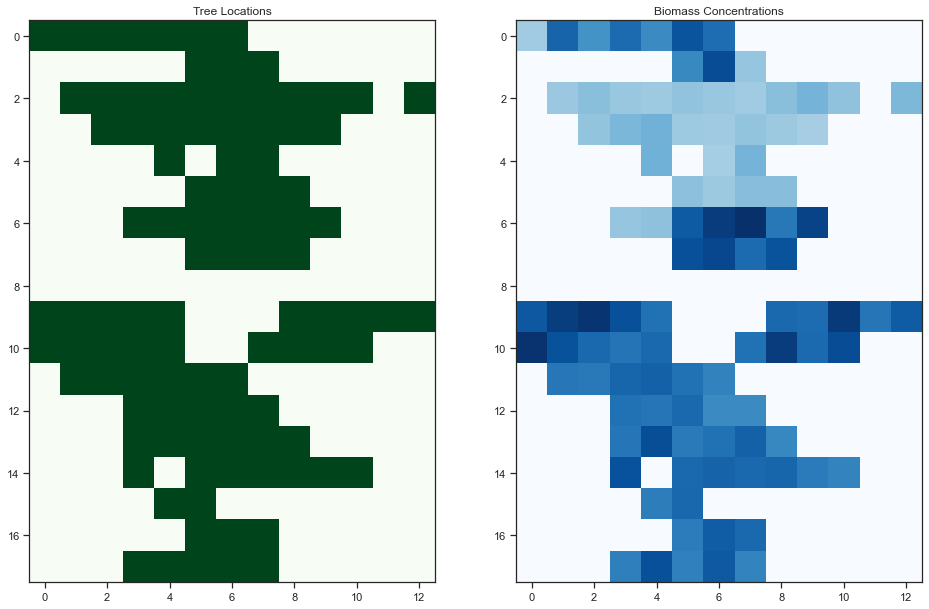

In [11]:
initial_locations = get_raster_data(site, counts=True)
initial_biomass = get_raster_data(site, var='biomass')

sns.set_style("ticks")
fig = plt.figure(figsize=(16,12))
plt.subplot(121)
plt.imshow(initial_locations, cmap='Greens')
plt.title("Tree Locations")
plt.subplot(122)
plt.title("Biomass Concentrations")
plt.imshow(initial_biomass, cmap='Blues')
#plt.colorbar(label = 'Biomass - Kg')
plt.show()

## 2. Running the scenario

In [12]:
for i in range(scenario_params['time_horizon_years']):
    site.step()

## 3. Analysis

### 3.1 Individual tree level inspections 

In [14]:
# Tree level individual variables
fname_output_trees = resource_filename("src", "gus/outputs/trees_yearly.json")
df_out_tree = site.datacollector.get_agent_vars_dataframe()
df_out_tree.to_csv(fname_output_trees, index=True)
df_out_tree.tail()

species        dbh    height    crownH    crownW  \
Step AgentID                                                     
50   160       decidu  11.879616  9.556040  4.986864  4.318415   
     161      conifer   9.276881  5.923177  3.827284  2.382624   
     162       decidu  10.132756  8.765093  4.515529  3.910702   
     163       decidu  10.146746  8.771664  4.519360  3.914007   
     164      conifer   9.337982  5.958062  3.843587  2.394136   

              canopy_overlap       cle  condition   dieback    biomass  \
Step AgentID                                                             
50   160            0.981876  0.513768       good  0.015630  62.067878   
     161            0.500000  0.717328       dead  1.000000  29.208986   
     162            0.961701  0.511353  excellent  0.004827  43.394367   
     163            1.000000  0.472162  excellent  0.004343  43.529301   
     164            0.570022  0.690947  excellent  0.002541  29.681795   

                   seq     carbon    deroot  detrunk   mulched     burnt  \
Step AgentID                                                               
50   160      3.279277  31.033939  0.000000      0.0  0.024253  0.000000   
     161      0.000000  14.604493  3.797168      0.0  0.000000  7.565127   
     162      2.689635  21.697183  0.000000      0.0  0.005236  0.000000   
     163      2.496065  21.764650  0.000000      0.0  0.000000  0.004726   
     164      1.577301  14.840897  0.000000      0.0  0.001885  0.000000   

             coordinates  
Step AgentID              
50   160         (10, 8)  
     161         (16, 7)  
     162          (9, 2)  
     163          (3, 3)  
     164          (0, 3)

In [15]:
Specific_Tree = df_out_tree.xs(42, level="AgentID")
Specific_Tree.tail()

,species,dbh,height,crownH,crownW,canopy_overlap,cle,condition,dieback,biomass,seq,carbon,deroot,detrunk,mulched,burnt,coordinates
Step,,,,,,,,,,,,,,,,,
46,decidu,44.140716,19.494946,11.162040,10.065018,1.0,0.568885,excellent,0.006,1190.078094,13.614320,595.039047,0.0,0.0,0.178512,0.0,"(6, 8)"
47,decidu,44.569099,19.597491,11.211753,10.118567,1.0,0.566053,excellent,0.005,1216.225093,13.073499,608.112546,0.0,0.0,0.152028,0.0,"(6, 8)"
48,decidu,44.978712,19.695123,11.258496,10.169211,1.0,0.567930,excellent,0.004,1241.522076,12.648492,620.761038,0.0,0.0,0.124152,0.0,"(6, 8)"
49,decidu,45.375858,19.789396,11.303077,10.217793,1.0,0.565888,excellent,0.005,1266.325707,12.401816,633.162854,0.0,0.0,0.158291,0.0,"(6, 8)"
50,decidu,45.778885,19.884681,11.347575,10.266570,1.0,0.565221,excellent,0.004,1291.775619,12.724956,645.887810,0.0,0.0,0.129178,0.0,"(6, 8)"


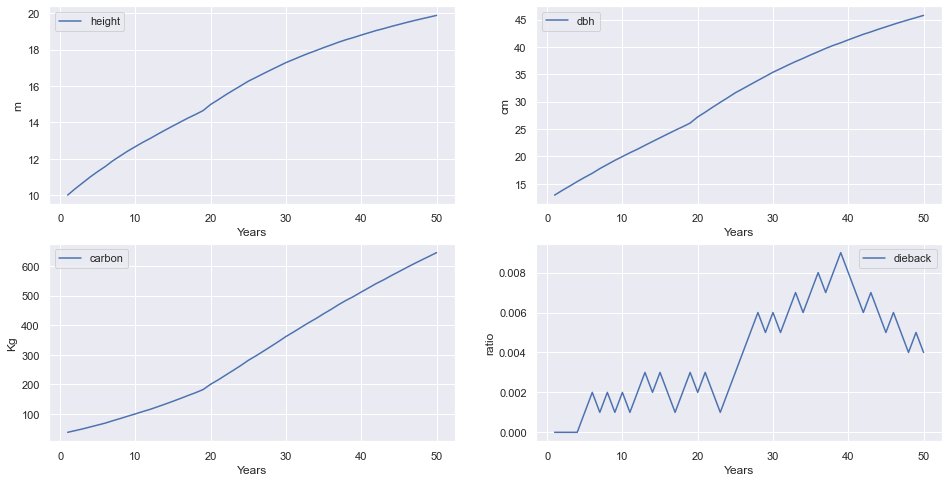

In [16]:
sns.set_theme()
fig = plt.figure(figsize=(16,8))
plt.subplot(221)
Specific_Tree.height.plot()
plt.xlabel('Years')
plt.ylabel('m')
plt.legend()
plt.subplot(222)
Specific_Tree.dbh.plot()
plt.xlabel('Years')
plt.ylabel('cm')
plt.legend()
plt.subplot(223)
Specific_Tree.carbon.plot()
plt.xlabel('Years')
plt.ylabel('Kg')
plt.legend()
plt.subplot(224)
Specific_Tree.dieback.plot()
plt.xlabel('Years')
plt.ylabel('ratio')
plt.legend()
plt.show()

### 3.2 Site level inspections

In [17]:
# Site level aggregate variables
df_out_site = site.datacollector.get_model_vars_dataframe()
df_out_site.tail()

,Storage,Seq,Released,Alive,Dead,Critical,Dying,Poor,Replaced,Seq_std
45,45311.483953,1045.000799,59.345755,100,0,0,0,0,60,6.245658
46,46293.479713,981.995759,437.134905,97,3,0,0,0,60,6.030728
47,47298.086510,957.848721,236.509101,99,1,0,0,0,63,5.911174
48,48275.867728,964.517621,144.855479,100,0,0,0,0,64,5.844292
49,49255.880936,980.013208,343.048932,97,3,0,0,0,64,6.022033


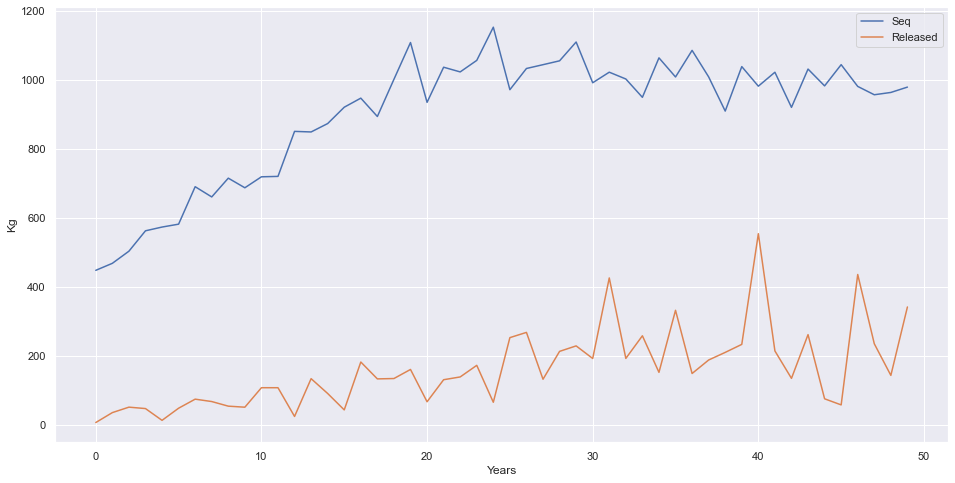

In [18]:
fig = plt.figure(figsize=(16,8))
df_out_site.Seq.plot()
df_out_site.Released.plot()
plt.xlabel('Years')
plt.ylabel('Kg')
plt.legend()
plt.show()

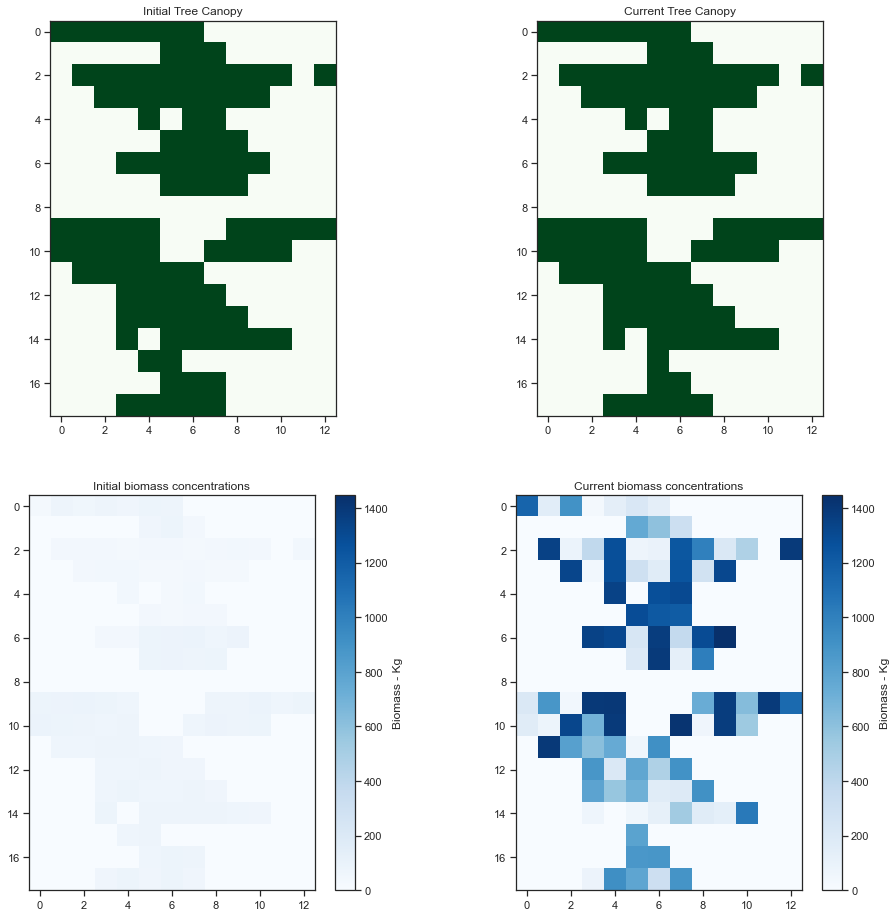

In [19]:
locations = get_raster_data(site, counts=True)
biomass = get_raster_data(site, var='biomass')

sns.set_style("ticks")
fig = plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(initial_locations, cmap='Greens')
plt.title("Initial Tree Canopy")

plt.subplot(222)
plt.imshow(locations, cmap='Greens')
plt.title("Current Tree Canopy")

plt.subplot(223)
plt.title("Initial biomass concentrations")
plt.imshow(initial_biomass, cmap='Blues', vmin=0, vmax=biomass.max())
plt.colorbar(label = 'Biomass - Kg')

plt.subplot(224)
plt.title("Current biomass concentrations")
plt.imshow(biomass, cmap='Blues')
plt.colorbar(label = 'Biomass - Kg')
plt.show()